# I. Imports

In [2]:
import pandas as pd
import cv2
import os, shutil
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import random as rd
from random import *

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical

import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout
from keras import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.metrics import f1_score, confusion_matrix
from skimage.transform import resize

from utils.extractPatches import extract_patches 



# II. Fonctions

In [3]:
def show_rdm_img(directory) : 
    i = randint(0, len(directory))
    filename = directory.filepaths[i]
    path = filename.split("\\")[0]
    
    filename = filename.split("\\")[1]

    img = cv2.imread(os.path.join(path,filename))
    print(img[0][0])
    plt.imshow(img)

In [4]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

In [5]:
def plot_multiclass_heatmap(y_test, y_predict, labels):

    y_pred = np.argmax(y_predict, axis=-1)
    y_true=np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_true, y_pred)

    cm_normalized = []
    for ligne in cm : 
        sum = np.sum(ligne)
        new_ligne = []
        for value in ligne : 
            new_ligne.append(value/sum)
        cm_normalized.append(new_ligne)

    class_names = list(labels)

    # Plot confusion matrix in a beautiful manner
    plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(cm_normalized, annot=True, ax = ax, fmt = 'g'); 

    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    plt.show()

In [6]:
def plt_box(plt, coords, linewidth, color) : 
    x1 = coords[0]
    y1 = coords[1]
    x2 = coords[2] +x1
    y2 = coords[3] +y1
    plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color)
    plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color)
    plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color)
    plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color)

In [87]:
# def generate_rdm_boxes_from_box (coords, delta_dist,delta_taille, w_frame, h_frame) :
#     x = coords[0]
#     y = coords[1] 
#     w = coords[2]
#     h = coords[3]

#     rdm_bboxes = []

#     # print(x,y,w,h,w_frame,h_frame)
#     # générer des boites de même taille mais à des positions différentes
#     for x_new in range(x-delta_dist, x+delta_dist,5) : 
#         for y_new in range(y-delta_dist,y+delta_dist,5) : 
#             if(x_new<=w_frame and y_new <=h_frame) : 
#                 for w_new in range(w-delta_taille, w+delta_taille,5) : 
#                     for h_new in range(h-delta_taille, h+delta_taille,5) : 
#                         w_new = min(w_new,w_frame-x_new)
#                         h_new = min(h_new,h_frame -y_new)
#                         new_coords = (x_new,y_new,w,h)
#                         # print(new_coords)
#                         rdm_bboxes.append(new_coords)
#     return rdm_bboxes
    

In [41]:
def generate_rdm_boxes_from_box (coords_prev_box, delta_dist,delta_taille, w_frame, h_frame, w_lim,h_lim) :
    x_prev = coords_prev_box[0]
    y_prev = coords_prev_box[1] 
    w_prev = coords_prev_box[2]
    h_prev = coords_prev_box[3]

    rdm_bboxes = []


    # Génération de boîtes autour de la boîte de la frame précédente
    for x_new in range(x_prev-delta_dist, x_prev+delta_dist,5) : 
        for y_new in range(y_prev-delta_dist,y_prev+delta_dist,5) : 
            if(x_new<w_frame and y_new <h_frame) : 
                for w_new in range(w_prev-delta_taille, w_prev+delta_taille,5) : 
                    for h_new in range(h_prev-delta_taille, h_prev+delta_taille,5) : 
                        w_new = min(w_new,w_frame-x_new)
                        h_new = min(h_new,h_frame -y_new)
                        new_coords = (x_new,y_new,w_new,h_new)
                        # pour éviter d'avoir des ox de 5 pixels de hauteur ou largeurs qui seraient très petites
                        if(w_new > w_lim and h_new > h_lim) : 
                            rdm_bboxes.append(new_coords)


    # on sélectionne aléatoirement 30 box parmi celles générées
    boxes = []
    for i in range(30) : 
        index = randint(0,len(rdm_bboxes))
        boxes.append(rdm_bboxes[index])

    return boxes

In [8]:
def preprocess_image(img) : 
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = resize(img_rgb, (227,227,3))
    return preprocess_input(img_resize)


In [9]:
def get_num_first_frame_with_coord(list_bbox_path) : 
    with open(list_bbox_path) as fp: 
        lines = fp.readlines() 
        for line in lines: 
            elts = line.split()
            if len(elts) == 2:
                assert(elts[1] == "0")
            else:
                assert(len(elts) > 2)
                assert(elts[1] == "1") #only one bbox per frame
                frame_number = (int)(elts[0])
                x = (int)(elts[2])
                y = (int)(elts[3])
                w = (int)(elts[4])
                h = (int)(elts[5])
                break
    return (frame_number, (x, y, w, h))

In [10]:
def get_frame_from_number(video_path, frame_nb) : 
    cap = cv2.VideoCapture(video_path)
    if (not cap.isOpened()):
        print("ERROR: unable to read video:", video_path)
        sys.exit()

    frame_number=1
    _, frame = cap.read()
    while frame_number != frame_nb : 
        frame_number+=1
        _, frame = cap.read()
    return frame

In [47]:
def get_nb_frames_video(video_path) : 
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return length
    

# III. Constantes

In [11]:
__original_dataset_path__ = "./DB/"
__train_path__ = __original_dataset_path__+'train/'
__test_path__ = __original_dataset_path__+'test/'
__val_path__ = __original_dataset_path__+'validation/'
__video_path__ = 'VIDEOS'
__bboxes_path__ = 'GT'

# IV. Modèle de classification

## 1. Création de jeux de données de train, validation et test

In [14]:
generator = ImageDataGenerator(preprocessing_function=preprocess_input)

### a. Jeu de données de validation

#### Modification de la DB

In [9]:
# __validation_proportion__ = 0.2

In [7]:
# for dirname in os.listdir(__train_path__) : 
#     print(f"Il y a {len(os.listdir(__train_path__+dirname))} images dans {dirname}")

Il y a 1019 images dans Bowl
Il y a 874 images dans CanOfCocaCola
Il y a 1024 images dans MilkBottle
Il y a 1032 images dans Rice
Il y a 787 images dans Sugar


In [6]:
# __validation_path__ = os.path.join(__original_dataset_path__, 'validation/')
# os.mkdir(__validation_path__)

In [10]:
# for classe in os.listdir(__train_path__) : 
#     classe_path =  os.path.join(__validation_path__, classe+'/')
#     os.mkdir(classe_path)
#     len_validation = int(len(os.listdir(__train_path__+classe))*__validation_proportion__)
#     src_path = __train_path__+classe+'/'
#     dst_path = classe_path

#     for _ in range(len_validation) : 
#         rdm_filename = choice(os.listdir(__train_path__+classe+'/'))
#         src_path_complete = src_path + rdm_filename
#         dst_path_complete = dst_path + rdm_filename
#         shutil.copyfile(src_path_complete, dst_path_complete)
#         os.remove(src_path_complete)

#### Création des données

In [15]:
val_img = generator.flow_from_directory(
    directory='./DB/validation/', target_size=(227, 227), color_mode='rgb', classes=None,
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='png',
    follow_links=False, interpolation='nearest'
)

val_img.num_classes
val_img.class_indices
val_labels = to_categorical(val_img.classes)
len(val_img.filenames)

Found 944 images belonging to 5 classes.


944

### b. Jeu de données de train

In [16]:
train_img = generator.flow_from_directory(
    directory='./DB/train/', target_size=(227, 227), color_mode='rgb', classes=None,
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='png',
    follow_links=False, interpolation='nearest'
)


train_img.num_classes
train_img.class_indices
train_labels = to_categorical(train_img.classes)
len(train_img.filenames)

Found 3792 images belonging to 5 classes.


3792

### c. Jeu de données de test

In [17]:
test_img = generator.flow_from_directory(
    directory='./DB/test/', target_size=(227, 227), color_mode='rgb', classes=None,
    class_mode='categorical', batch_size=32, shuffle=False, seed=None,
    save_to_dir=None, save_prefix='', save_format='png',
    follow_links=False, subset=None, interpolation='nearest'
)

test_img.num_classes
test_img.class_indices
test_labels = to_categorical(test_img.classes)
len(test_img.filenames)

Found 3568 images belonging to 5 classes.


3568

### d. Labels des classes

In [18]:
class_labels = os.listdir(__train_path__)
__nb_classes__ = len(class_labels)

## 2. Visualisation des données

In [46]:
val_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [47]:
train_labels
# len(train_labels)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [48]:
test_labels
# len(test_labels)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [62]:
i = randint(0, len(val_img))
filename = val_img.filepaths[i]
path = filename.split("\\")[0]
    
filename = filename.split("\\")[1]

img = cv2.imread(os.path.join(path,filename))
print(img[0][0])
print(img.shape)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img_rgb[0][0])
print(img_rgb.shape)

img_resize = resize(img_rgb, (227,227,3))
print(img_resize.shape)

preprocess_img = preprocess_input(img_resize)
print(preprocess_img.shape)


[ 56  93 124]
(227, 227, 3)
[124  93  56]
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


[26 34 43]


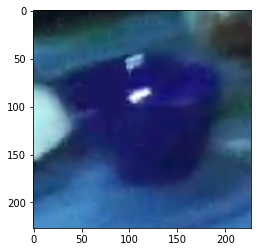

In [49]:
show_rdm_img(val_img)

[ 78 130 170]


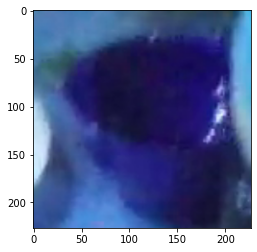

In [50]:
show_rdm_img(train_img)

[ 69 122 185]


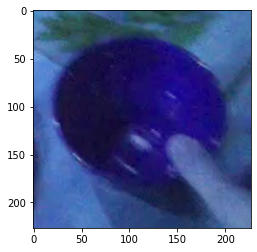

In [51]:
show_rdm_img(test_img)

In [117]:
test_img.__getitem__(0)
# 1er batch : (x,y) avec x tableau avec les images du batch, 
# et y tableau avec les labels corresp

(array([[[[ -69.939    ,  -86.779    ,  -97.68     ],
          [ -71.939    ,  -88.779    ,  -99.68     ],
          [ -69.939    ,  -89.779    ,  -99.68     ],
          ...,
          [ -45.939003 ,  -63.779    ,  -78.68     ],
          [ -49.939003 ,  -67.779    ,  -82.68     ],
          [ -47.939003 ,  -65.779    ,  -80.68     ]],
 
         [[ -70.939    ,  -88.779    ,  -96.68     ],
          [ -72.939    ,  -89.779    , -100.68     ],
          [ -71.939    ,  -91.779    , -101.68     ],
          ...,
          [ -44.939003 ,  -62.779    ,  -77.68     ],
          [ -45.939003 ,  -65.779    ,  -80.68     ],
          [ -46.939003 ,  -64.779    ,  -79.68     ]],
 
         [[ -72.939    ,  -90.779    ,  -98.68     ],
          [ -73.939    ,  -91.779    ,  -99.68     ],
          [ -71.939    ,  -92.779    ,  -99.68     ],
          ...,
          [ -42.939003 ,  -62.779    ,  -77.68     ],
          [ -45.939003 ,  -65.779    ,  -80.68     ],
          [ -46.939003 ,  -67.7

In [118]:
test_img.__len__()
# 112 batches de 32 images 

112

## 3. Création du modèle

In [19]:
__learning_rate__ = 1e-5
__epochs__ = 50
__x_shape__ = (227,227,3)

### a. Modele VGG

In [116]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, mode='max', min_lr=__learning_rate__)
filepath="models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

baseModel = VGG16(weights='imagenet', include_top=False, input_shape=__x_shape__)
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### b. Finetuning

In [66]:
for layer in baseModel.layers[:15]:
	layer.trainable = False
	
x = baseModel.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(__nb_classes__, activation='softmax')(x)

finalModel= Model(inputs=baseModel.input, outputs=x)
finalModel.summary()

opt = Adam(learning_rate=__learning_rate__)
finalModel.compile(loss="categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [67]:
history = finalModel.fit(train_img, validation_data=val_img, epochs=__epochs__, callbacks=[lr_reduce, earlyStopping, checkpoint])


Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 2.9152 - accuracy: 0.5786
Epoch 00001: val_accuracy improved from -inf to 0.93114, saving model to models\weights-improvement-01-0.93.hdf5
119/119 [==============================] - 1168s 10s/step - loss: 2.9152 - accuracy: 0.5786 - val_loss: 0.1880 - val_accuracy: 0.9311 - lr: 1.0000e-05
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.8987
Epoch 00002: val_accuracy improved from 0.93114 to 0.97881, saving model to models\weights-improvement-02-0.98.hdf5
119/119 [==============================] - 1178s 10s/step - loss: 0.3395 - accuracy: 0.8987 - val_loss: 0.0556 - val_accuracy: 0.9788 - lr: 1.0000e-05
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9597
Epoch 00003: val_accuracy improved from 0.97881 to 0.98835, saving model to models\weights-improvement-03-0.99.hdf5
119/119 [==============================] - 1193s 10s/step - loss:

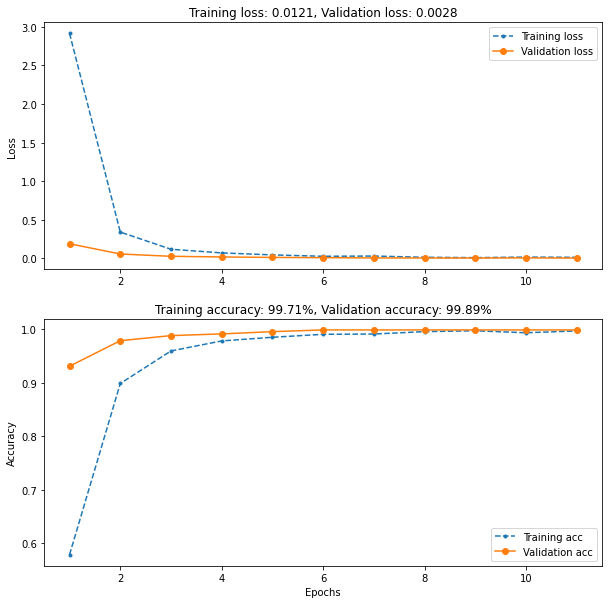

In [68]:
plot_loss_acc(history)

## 4. Prédictions

In [20]:
from keras import models

# bon modèle avec input_shape = (227,227,3)
finalModel = models.load_model('models\weights-improvement-06-1.00.hdf5')

In [71]:
y_predict = finalModel.predict(test_img)

In [72]:
y_predict_binary = []
for y in y_predict:
    binary = np.zeros(__nb_classes__)
    binary[np.argmax(y)] = 1
    y_predict_binary.append(binary)
y_predict_binary = np.array(y_predict_binary)

In [73]:
y_predict_binary

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [74]:
y_test = test_labels
y_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [75]:
f1_score(y_test, y_predict_binary, average="macro")

0.860845478422793

In [26]:
y_predict

array([[1.00000000e+00, 1.81639565e-17, 2.27608560e-21, 6.25491073e-14,
        4.54449136e-23],
       [1.00000000e+00, 6.48117972e-18, 2.61673215e-21, 4.54085798e-13,
        6.25997621e-20],
       [1.00000000e+00, 2.40542178e-12, 2.84542084e-16, 3.68450770e-10,
        8.66156986e-14],
       ...,
       [1.15407228e-12, 6.90805690e-10, 5.42938307e-12, 8.94139485e-10,
        1.00000000e+00],
       [6.77992601e-13, 5.02125841e-10, 1.12474864e-11, 7.03136549e-10,
        1.00000000e+00],
       [5.71078731e-12, 5.87350613e-09, 1.43975651e-10, 6.81750700e-09,
        1.00000000e+00]], dtype=float32)

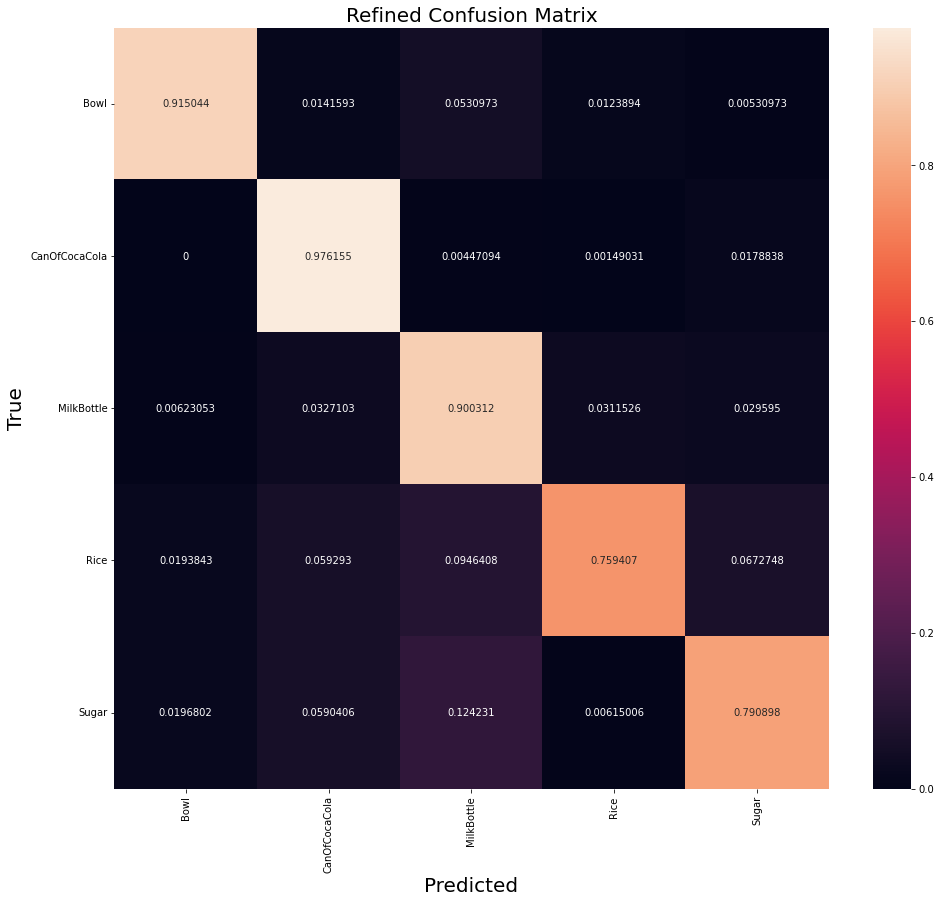

In [76]:
# labels = test_img.class_indices.keys()
plot_multiclass_heatmap(y_test, y_predict, class_labels)

**Commentaire** : on est plutôt satisfait car on a les plus hautes valeurs sur la diagonales, ce qui signifie que notre modèle a de bonnes prédictions. Cependant, d'autres valeurs autres que sur la diagonale sortent un peu du lot.
Par exemple, le sucre est détecté en temps que bouteille de lait dans 12.4% des cas, et le riz est détecté en tant que bouteille de lait dans 9,4% des cas.

**TODO** : essayer d'afficher les images pour lesquelles les prédictions sont les + mauvaises pour les analyser

# V. Traitement de la vidéo

## 1. Récupération de la boîte englobante de début

In [21]:
rdm_video_filename = rd.choice(os.listdir(__video_path__))
rdm_video_path = os.path.join(__video_path__, rdm_video_filename)

list_bbox_filename = rdm_video_filename.split('.')[0] +"_2_bboxes.txt"
list_bbox_path = os.path.join(__bboxes_path__,list_bbox_filename)

In [22]:
num_first_frame_with_coord  = get_num_first_frame_with_coord(list_bbox_path)
print(f"La première frame de la vidéo {rdm_video_filename} où l'objet apparait est la n°{num_first_frame_with_coord[0]}, les coordonnées de la boite sont :{num_first_frame_with_coord[1]} ")

La première frame de la vidéo MilkBottlePlace2Subject2.mp4 où l'objet apparait est la n°15, les coordonnées de la boite sont :(842, 294, 92, 190) 


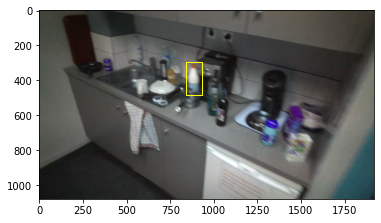

In [23]:
import matplotlib.pyplot as plt

first_frame = get_frame_from_number(rdm_video_path, num_first_frame_with_coord[0])
plt.imshow(first_frame)
box_first_frame_coords = num_first_frame_with_coord[1]
plt_box(plt, box_first_frame_coords, 1, "yellow")

## 2. Récupération de la frame suivante et génération de boites aléatoires

In [35]:
# On récupère la frame d'après
num_next_frame = num_first_frame_with_coord[0] + 1
next_frame = get_frame_from_number(rdm_video_path, num_next_frame)
rdm_boxes = generate_rdm_boxes_from_box(box_first_frame_coords,50,50,next_frame.shape[1],next_frame.shape[0],5,5)

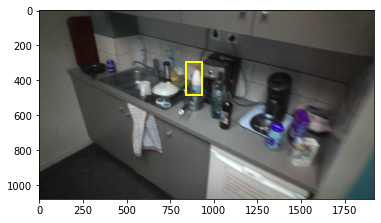

In [36]:
plt.imshow(next_frame)
plt_box(plt, box_first_frame_coords, 2, "yellow")

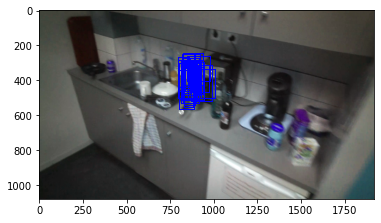

In [37]:
plt.imshow(next_frame)
for box in rdm_boxes : 
    plt_box(plt, box, 1, "blue")

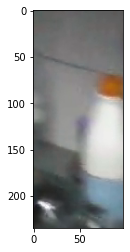

In [38]:
rdm_index = rd.randint(0,len(rdm_boxes)-1)
box = rdm_boxes[rdm_index]
img = next_frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
plt.imshow(img)

## 3. Généralisation

In [26]:
# test opur savoir que donner à predict
y_predict = finalModel.predict(test_img.__getitem__(0)[0])

In [27]:
valid_input = test_img.__getitem__(0)[0]
valid_input.shape

(32, 227, 227, 3)

In [42]:
__batch_size__ = 3
pred_boxes = []
num_first_frame, coords_first_box = get_num_first_frame_with_coord(list_bbox_path)
pred_boxes.append(coords_first_box)

cap = cv2.VideoCapture(rdm_video_path)
if (not cap.isOpened()):
    print("ERROR: unable to read video:", rdm_video_path)
    sys.exit()

label = rdm_video_filename.split('Place')[0]
label_id = class_labels.index(label)

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break
    
    if i > num_first_frame:
        newBoxes = generate_rdm_boxes_from_box(pred_boxes[-1], 50,50,frame.shape[1],frame.shape[0],5,5)

        proba = []

        batch_imgs = []
        for num_box,box in enumerate(newBoxes) : 
            if ((len(batch_imgs) < __batch_size__) and num_box < len(newBoxes)) : 
                # img = frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
                img = frame[box[0]:box[0]+box[2],box[1]:box[1]+box[3]]
                print(img.shape)
                img_pre = preprocess_image(img)
                batch_imgs.append(img_pre)

            else:
                batch_imgs = np.array(batch_imgs)
                model_prediction_batch = finalModel.predict((batch_imgs))
                for pred in model_prediction_batch : 
                    proba.append(pred[label_id])
                batch_imgs = []
                
        bestBox = newBoxes[np.argmax(proba)]
        pred_boxes.append(bestBox)        
    
    i+=1

(127, 225, 3)
(117, 160, 3)
(107, 210, 3)
(57, 160, 3)
(52, 220, 3)
(127, 170, 3)
(82, 230, 3)
(107, 155, 3)
(42, 215, 3)
(47, 195, 3)
(42, 210, 3)
(117, 205, 3)
(117, 180, 3)
(67, 190, 3)
(87, 160, 3)
(82, 155, 3)
(72, 205, 3)
(137, 150, 3)
(57, 160, 3)
(122, 195, 3)
(132, 170, 3)
(102, 230, 3)
(107, 165, 3)
(152, 190, 3)
(57, 170, 3)
(67, 180, 3)
(112, 195, 3)
(57, 155, 3)
(142, 185, 3)
(77, 125, 3)
(122, 180, 3)
(142, 110, 3)
(82, 190, 3)
(122, 140, 3)
(57, 135, 3)
(137, 140, 3)
(137, 185, 3)
(132, 110, 3)
(127, 155, 3)
(62, 180, 3)
(92, 170, 3)
(87, 160, 3)
(102, 125, 3)
(67, 165, 3)
(122, 140, 3)
(147, 185, 3)
(57, 230, 3)
(42, 225, 3)
(122, 190, 3)
(32, 230, 3)
(42, 165, 3)
(62, 210, 3)
(47, 160, 3)
(72, 190, 3)
(127, 155, 3)
(32, 190, 3)
(37, 170, 3)
(122, 200, 3)
(57, 190, 3)
(122, 225, 3)
(127, 225, 3)
(52, 220, 3)
(67, 180, 3)
(37, 235, 3)
(122, 145, 3)
(77, 185, 3)
(102, 165, 3)
(57, 175, 3)
(57, 155, 3)
(62, 180, 3)
(82, 170, 3)
(62, 185, 3)
(122, 200, 3)
(117, 190, 3)
(112

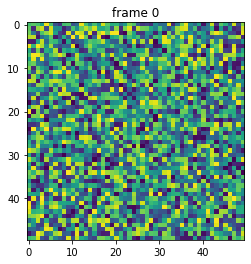

In [38]:
# import matplotlib.pyplot as plt
# import numpy as np

# np.random.seed(19680801)
# data = np.random.random((50, 50, 50))

# fig, ax = plt.subplots()

# for i in range(len(data)):
#     ax.cla()
#     ax.imshow(data[i])
#     ax.set_title("frame {}".format(i))
#     # Note that using time.sleep does *not* work here!
#     plt.pause(0.1)

In [49]:
frames_with_obj = [get_frame_from_number(rdm_video_path, i) for i in range(get_nb_frames_video(rdm_video_path)) if i >= num_first_frame]

In [50]:
assert(len(frames_with_obj) == len(pred_boxes))

In [52]:
import cv2
import os


for idx,frame_with_obj in enumerate(frames_with_obj) : 
    # frame = cv2.imread(frame_with_obj, 1)
    start_point= (pred_boxes[0],pred_boxes[1])
    end_point = (pred_boxes[0]+pred_boxes[2],pred_boxes[1]+pred_boxes[3])
    img_to_show = cv2.rectangle(frame_with_obj, start_point, end_point, (255,0,0), 2) 
    
    cv2.imshow('window', img_to_show)  

    key = cv2.waitKey(3000)#pauses for 3 seconds before fetching next image
    if key == 27:#if ESC is pressed, exit loop
        cv2.destroyAllWindows()
        break



# folder_path = __train_path__+'/Bowl'

# for path in os.listdir(folder_path):#loop to read one image at a time 
#     imgpath = os.path.join(folder_path, path)

#     frame = cv2.imread(imgpath, 1)

#     # start_point = (box_first_frame_coords[0], box_first_frame_coords[1])
#     # end_point = (box_first_frame_coords[0]+box_first_frame_coords[2], box_first_frame_coords[1]+box_first_frame_coords[3])
#     start_point= (10,10)
#     end_point = (15,15)
#     img_to_show = cv2.rectangle(frame, start_point, end_point, (255,0,0), 2) 
    
#     cv2.imshow('window', img_to_show)  

#     key = cv2.waitKey(3000)#pauses for 3 seconds before fetching next image
#     if key == 27:#if ESC is pressed, exit loop
#         cv2.destroyAllWindows()
#         break


error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


In [112]:
# # code de base : ne pas toucher
# pred_boxes = []
# num_first_frame, coords_first_box = get_num_first_frame_with_coord(list_bbox_path)
# pred_boxes.append(coords_first_box)

# cap = cv2.VideoCapture(rdm_video_path)
# if (not cap.isOpened()):
#     print("ERROR: unable to read video:", rdm_video_path)
#     sys.exit()

# label = rdm_video_filename.split('Place')[0]
# label_id = class_labels.index(label)

# i = 0
# while cap.isOpened():
#     ret, frame = cap.read()
#     if ret == False:
#         break
    
#     if i > num_first_frame:
#         newBoxes = generate_rdm_boxes_from_box(pred_boxes[-1], 50,50,frame.shape[1],frame.shape[0])
#         proba = []

#         for box in newBoxes:
#             img = frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
#             img_pre = preprocess_image(img)
#             model_prediction = finalModel.predict((img_pre))
#             proba.append(model_prediction[label_id])
        
#         bestBox = newBoxes[np.argmax(proba)]
#         pred_boxes.append(bestBox)
    
#     i+=1

ValueError: in user code:

    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 227, 227, 3), found shape=(None, 227, 3)
